<a href="https://colab.research.google.com/github/TengGao/Customer_Churn_Prediction/blob/master/machine_learning_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import math
from collections import Counter
from sklearn.preprocessing import LabelEncoder

### Oridnary Least Square Fit Using Matrix Inversion Pesudo Code

1. Initializes an instance of the OrdinaryLeastSquares class, setting the beta attribute to None. This attribute will store the model coefficients after fitting.
2. Fitting the Model:
* Computes the matrix $X^tX$ and its inverse;
* Calculates $X^ty$;
* Derive the coefficient $\beta$ by $$\beta = (X^tX)^{-1}X^ty$$
3. Prediction by $y = X^t\beta$.

In [6]:
class OrdinaryLeastSquares:
    def __init__(self):
        self.beta = None  # Coefficients will be set after fitting the model

    def fit(self, X, y):
        # Step 1: Calculate X^T X
        XTX = np.dot(X.T, X)

        # Step 2: Calculate the inverse of X^T X
        XTX_inv = np.linalg.inv(XTX)

        # Step 3: Calculate X^T y
        XTy = np.dot(X.T, y)

        # Step 4: Calculate the coefficients (beta)
        self.beta = np.dot(XTX_inv, XTy)

    def predict(self, X):
        # Make predictions using the learned coefficients
        return np.dot(X, self.beta)

# Test
X = np.array([
    [1, 1],  # Added a column of ones already for the intercept
    [1, 2],
    [1, 3],
    [1, 4],
    [1, 5]
])
y = np.array([1, 2, 1.3, 3.75, 2.25])

model = OrdinaryLeastSquares()
model.fit(X, y)
print("Coefficients:", model.beta)

# Predicting values
predicted_y = model.predict(X)
print("Predicted values:", predicted_y)

Coefficients: [0.785 0.425]
Predicted values: [1.21  1.635 2.06  2.485 2.91 ]


In [2]:
class LinearRegressionGD:
    def __init__(self, learning_rate=0.1, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.beta = None  # Coefficients will be set after fitting the model

    def fit(self, X, y):
        m = len(X)
        X_b = np.c_[np.ones((m, 1)), X]  # Add intercept term
        self.beta = np.random.randn(X_b.shape[1], 1)  # Random initialization of parameters

        for iteration in range(self.n_iterations):
            gradients = -2/m * X_b.T @ (y - X_b @ self.beta)  # Using @ for matrix multiplication
            self.beta -= self.learning_rate * gradients

    def predict(self, X):
        X_b = np.c_[np.ones((len(X), 1)), X]  # Add intercept term
        return X_b @ self.beta  # Using @ for matrix multiplication

# Sample Data Generation
np.random.seed(0)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Create an instance of the LinearRegressionGD class
model = LinearRegressionGD(learning_rate=0.1, n_iterations=1000)
model.fit(X, y)  # Fit the model

# Make predictions
X_new = np.array([[0], [2]])
y_predict = model.predict(X_new)

print("Estimated coefficients:", model.beta)
print("Predictions:", y_predict)


Estimated coefficients: [[4.22215108]
 [2.96846751]]
Predictions: [[ 4.22215108]
 [10.1590861 ]]


In [9]:
# Implementing Decision Tree Classifier
# 1. Start at the root node with the whole dataset.
# 1. For each feature, calculate the potential information gain of splitting on that feature.
# 1. Choose the feature with the highest information gain.
# 1. Split the dataset into subsets using the chosen feature.
# 1. Recursively repeat the process for each subset until one of the stopping criteria is met (e.g., all members of a subset have the same class, the subset reaches a minimum size, or maximum depth is reached).
class DecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.features = X.shape[1]
        self.tree = self._build_tree(X, y, 0)

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        # Stop criteria
        if depth == self.max_depth or len(np.unique(y)) == 1:
            most_common_label = np.bincount(y).argmax()
            return {'label': most_common_label}

        # Find the best split
        best_gain = -1
        best_feature = None
        best_threshold = None
        for feature_index in range(num_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                gain = self._information_gain(X, y, feature_index, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold

        # Grow the tree recursively
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = X[:, best_feature] > best_threshold
        left_child = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return {'feature_index': best_feature, 'threshold': best_threshold, 'left': left_child, 'right': right_child, 'info_gain': best_gain}

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return -np.sum(probabilities * np.log2(probabilities))

    def _information_gain(self, X, y, feature_index, threshold):
        parent_entropy = self._entropy(y)
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold
        left_entropy = self._entropy(y[left_mask])
        right_entropy = self._entropy(y[right_mask])
        n = len(y)
        n_left, n_right = left_mask.sum(), right_mask.sum()
        child_entropy = (n_left / n) * left_entropy + (n_right / n) * right_entropy
        return parent_entropy - child_entropy

    def predict(self, X):
        predictions = [self._predict(inputs, self.tree) for inputs in X]
        return np.array(predictions)

    def _predict(self, inputs, tree):
        if 'label' in tree:
            return tree['label']
        feature_index = tree['feature_index']
        threshold = tree['threshold']
        if inputs[feature_index] <= threshold:
            return self._predict(inputs, tree['left'])
        else:
            return self._predict(inputs, tree['right'])

# Example Usage
from sklearn.datasets import load_iris
data = load_iris()
X, y = data.data, data.target
dt = DecisionTree(max_depth=3)
dt.fit(X, y)

Predicting
print(dt.predict(X[:5]))

# Example Usage 2
data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'Play Tennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}

df = pd.DataFrame(data)

# Encoding categorical data
label_encoder = LabelEncoder()
for column in df.columns:
    df[column] = label_encoder.fit_transform(df[column])

# Split features and target
X = df.drop('Play Tennis', axis=1).values
y = df['Play Tennis'].values

dt = DecisionTree(max_depth=3)
dt.fit(X, y)

# Predicting
print(dt.predict(X[:5]))

[0 0 1 0 1]


In [ ]:
# Python Implementation Of Support Vector Machine
class LinearSVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations
        self.w = None
        self.b = 0

    def fit(self, X, y):
        n, d = X.shape
        y_ = np.where(y <= 0, -1, 1)
        self.w = np.zeros(d)

        for _ in range(self.n_iterations):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.learning_rate * y_[idx]

    def predict(self, X):
        return np.sign(np.dot(X, self.w) - self.b)

# Example usage
from sklearn import datasets
X, y = datasets.make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40)
y = np.where(y == 0, -1, 1)  # Convert to -1, 1

# Training the model
model = LinearSVM()
model.fit(X, y)

# Predicting new data
predictions = model.predict(X)

In [ ]:
class KNearestNeighbors:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [np.sqrt(np.sum((x_train - x) ** 2)) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Extract the labels of the k nearest neighbors
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Majority vote, most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

# Example usage
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

# Splitting the dataset for the demonstration (normally use train-test split)
X_train, X_test = X[:100], X[100:]
y_train, y_test = y[:100], y[100:]

# Creating an instance of KNearestNeighbors with k=3
knn = KNearestNeighbors(k=3)
knn.fit(X_train, y_train)

# Making predictions
predictions = knn.predict(X_test)
print("Predicted labels:", predictions)


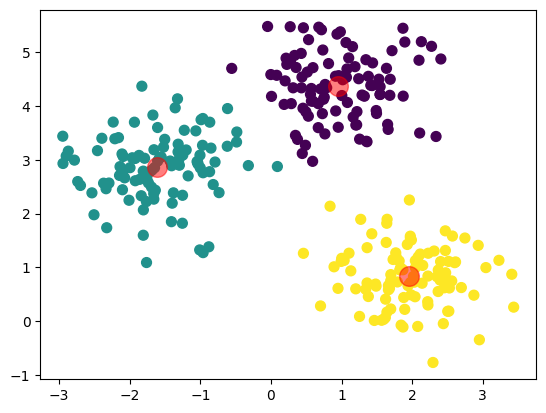

In [4]:
# Implement K-Mean Clustering
# Key Concepts of k-Means
# 1. Initialization:  Randomly select 𝑘. k points as the initial centroids or use smart initialization techniques like k-means++.
# 1. Assignment: Assign each point to the nearest centroid based on the Euclidean distance.
# 1. Update: Recalculate the centroids as the mean of the points assigned to each cluster.
# 1. Iteration: Repeat the assignment and update steps until convergence (i.e., when the assignments no longer change or the changes are minimal).

class KMeans:
    def __init__(self, k=3, tol=0.0001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self, data):
        self.centroids = {}

        # Initialize centroids by picking random data points
        for i in range(self.k):
            self.centroids[i] = data[np.random.randint(len(data))]

        for i in range(self.max_iter):
            self.clusters = {i: [] for i in range(self.k)}

            # Assign each data point to the closest centroid
            for point in data:
                distances = [np.linalg.norm(point - self.centroids[centroid]) for centroid in self.centroids]
                cluster = np.argmin(distances)
                self.clusters[cluster].append(point)

            prev_centroids = dict(self.centroids)

            # Recalculate centroids
            for cluster in self.clusters:
                self.centroids[cluster] = np.average(self.clusters[cluster], axis=0)

            optimized = True
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid - original_centroid) / original_centroid * 100.0) > self.tol:
                    optimized = False

            if optimized:
                break

    def predict(self, data):
        predictions = []
        for point in data:
            distances = [np.linalg.norm(point - self.centroids[centroid]) for centroid in self.centroids]
            prediction = distances.index(min(distances))
            predictions.append(prediction)
        return predictions

# Example usage
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

# Creating an instance of KMeans with k=3
model = KMeans(k=3)
model.fit(X)

# Making predictions
predictions = model.predict(X)

# Optionally, plotting the results
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=predictions, s=50, cmap='viridis')
centers = np.array(list(model.centroids.values()))
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.show()

In [5]:
class NeuralNetwork:
    def __init__(self, x, y):
        self.input      = x
        self.weights1   = np.random.rand(self.input.shape[1], 4)  # Weights for the hidden layer (4 neurons)
        self.weights2   = np.random.rand(4, 1)                   # Weights for the output layer
        self.y          = y
        self.output     = np.zeros(self.y.shape)  # Output layer results

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return z * (1 - z)

    def feedforward(self):
        self.layer1 = self.sigmoid(np.dot(self.input, self.weights1))
        self.output = self.sigmoid(np.dot(self.layer1, self.weights2))

    def backprop(self):
        # Application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output) * self.sigmoid_derivative(self.output)))
        d_weights1 = np.dot(self.input.T,  (np.dot(2*(self.y - self.output) * self.sigmoid_derivative(self.output), self.weights2.T) * self.sigmoid_derivative(self.layer1)))

        # Update the weights with the derivative (slope) of the loss function
        self.weights1 += d_weights1
        self.weights2 += d_weights2

    def train(self, iterations):
        for i in range(iterations):
            self.feedforward()
            self.backprop()


X = np.array([[0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1]])
y = np.array([[0],[1],[1],[0]])
nn = NeuralNetwork(X,y)

nn.train(iterations=1500)
print(nn.output)


[[0.00887877]
 [0.9700102 ]
 [0.97001992]
 [0.0367412 ]]
